In [1]:
import functions
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter, butter, iirnotch, filtfilt, sosfilt
from hosd_python.hosd import apply_hosd # library that I converted from MATLAB
from copy import deepcopy
import scipy.stats as stats
from picard import Picard
from sklearn.decomposition import FastICA as skFastICA



In [2]:
no_ica_chans = 18
fs=1000
span = 10*fs
offset = 100*fs 
ms2s = lambda x, _:f'{x/1000:g}' 
window_size=int(1400) # used for higher-order-spectral filtering
time_axis=np.linspace(0,int(window_size)-1,num=int(window_size))

In [3]:
data = functions.array_from_TDMSgroup("patients/P050/P050_S01_D2024-06-13_G39.tdms", "R002")
filtered_data = functions.butter_filter(data)
copied_data = deepcopy(data)

In [4]:
def bandpass_filter(dd, order=5):
    sos = butter(order, [1, 40], btype='band', output='sos', fs=1000)
    #band_stop=butter(bsto,bstfc,btype='bandstop',output='sos',fs=fs)
    data = deepcopy(dd)
    for i in range(data.shape[1]):
        data[:,i] = sosfilt(sos, data[:,i])
    return data

bp_data = bandpass_filter(copied_data[5000:, 1:])

In [5]:
n_comp = 30

ica = Picard(n_components=None, fun='logcosh', whiten='unit-variance', max_iter=400, tol=1e-5, ortho=True, extended=True)
filtered_data_np = np.array(bp_data)
ica_applied = ica.fit_transform(filtered_data_np)

kurtosis_values = [stats.kurtosis(ica_applied[:, j]) for j in range(ica_applied.shape[1])]

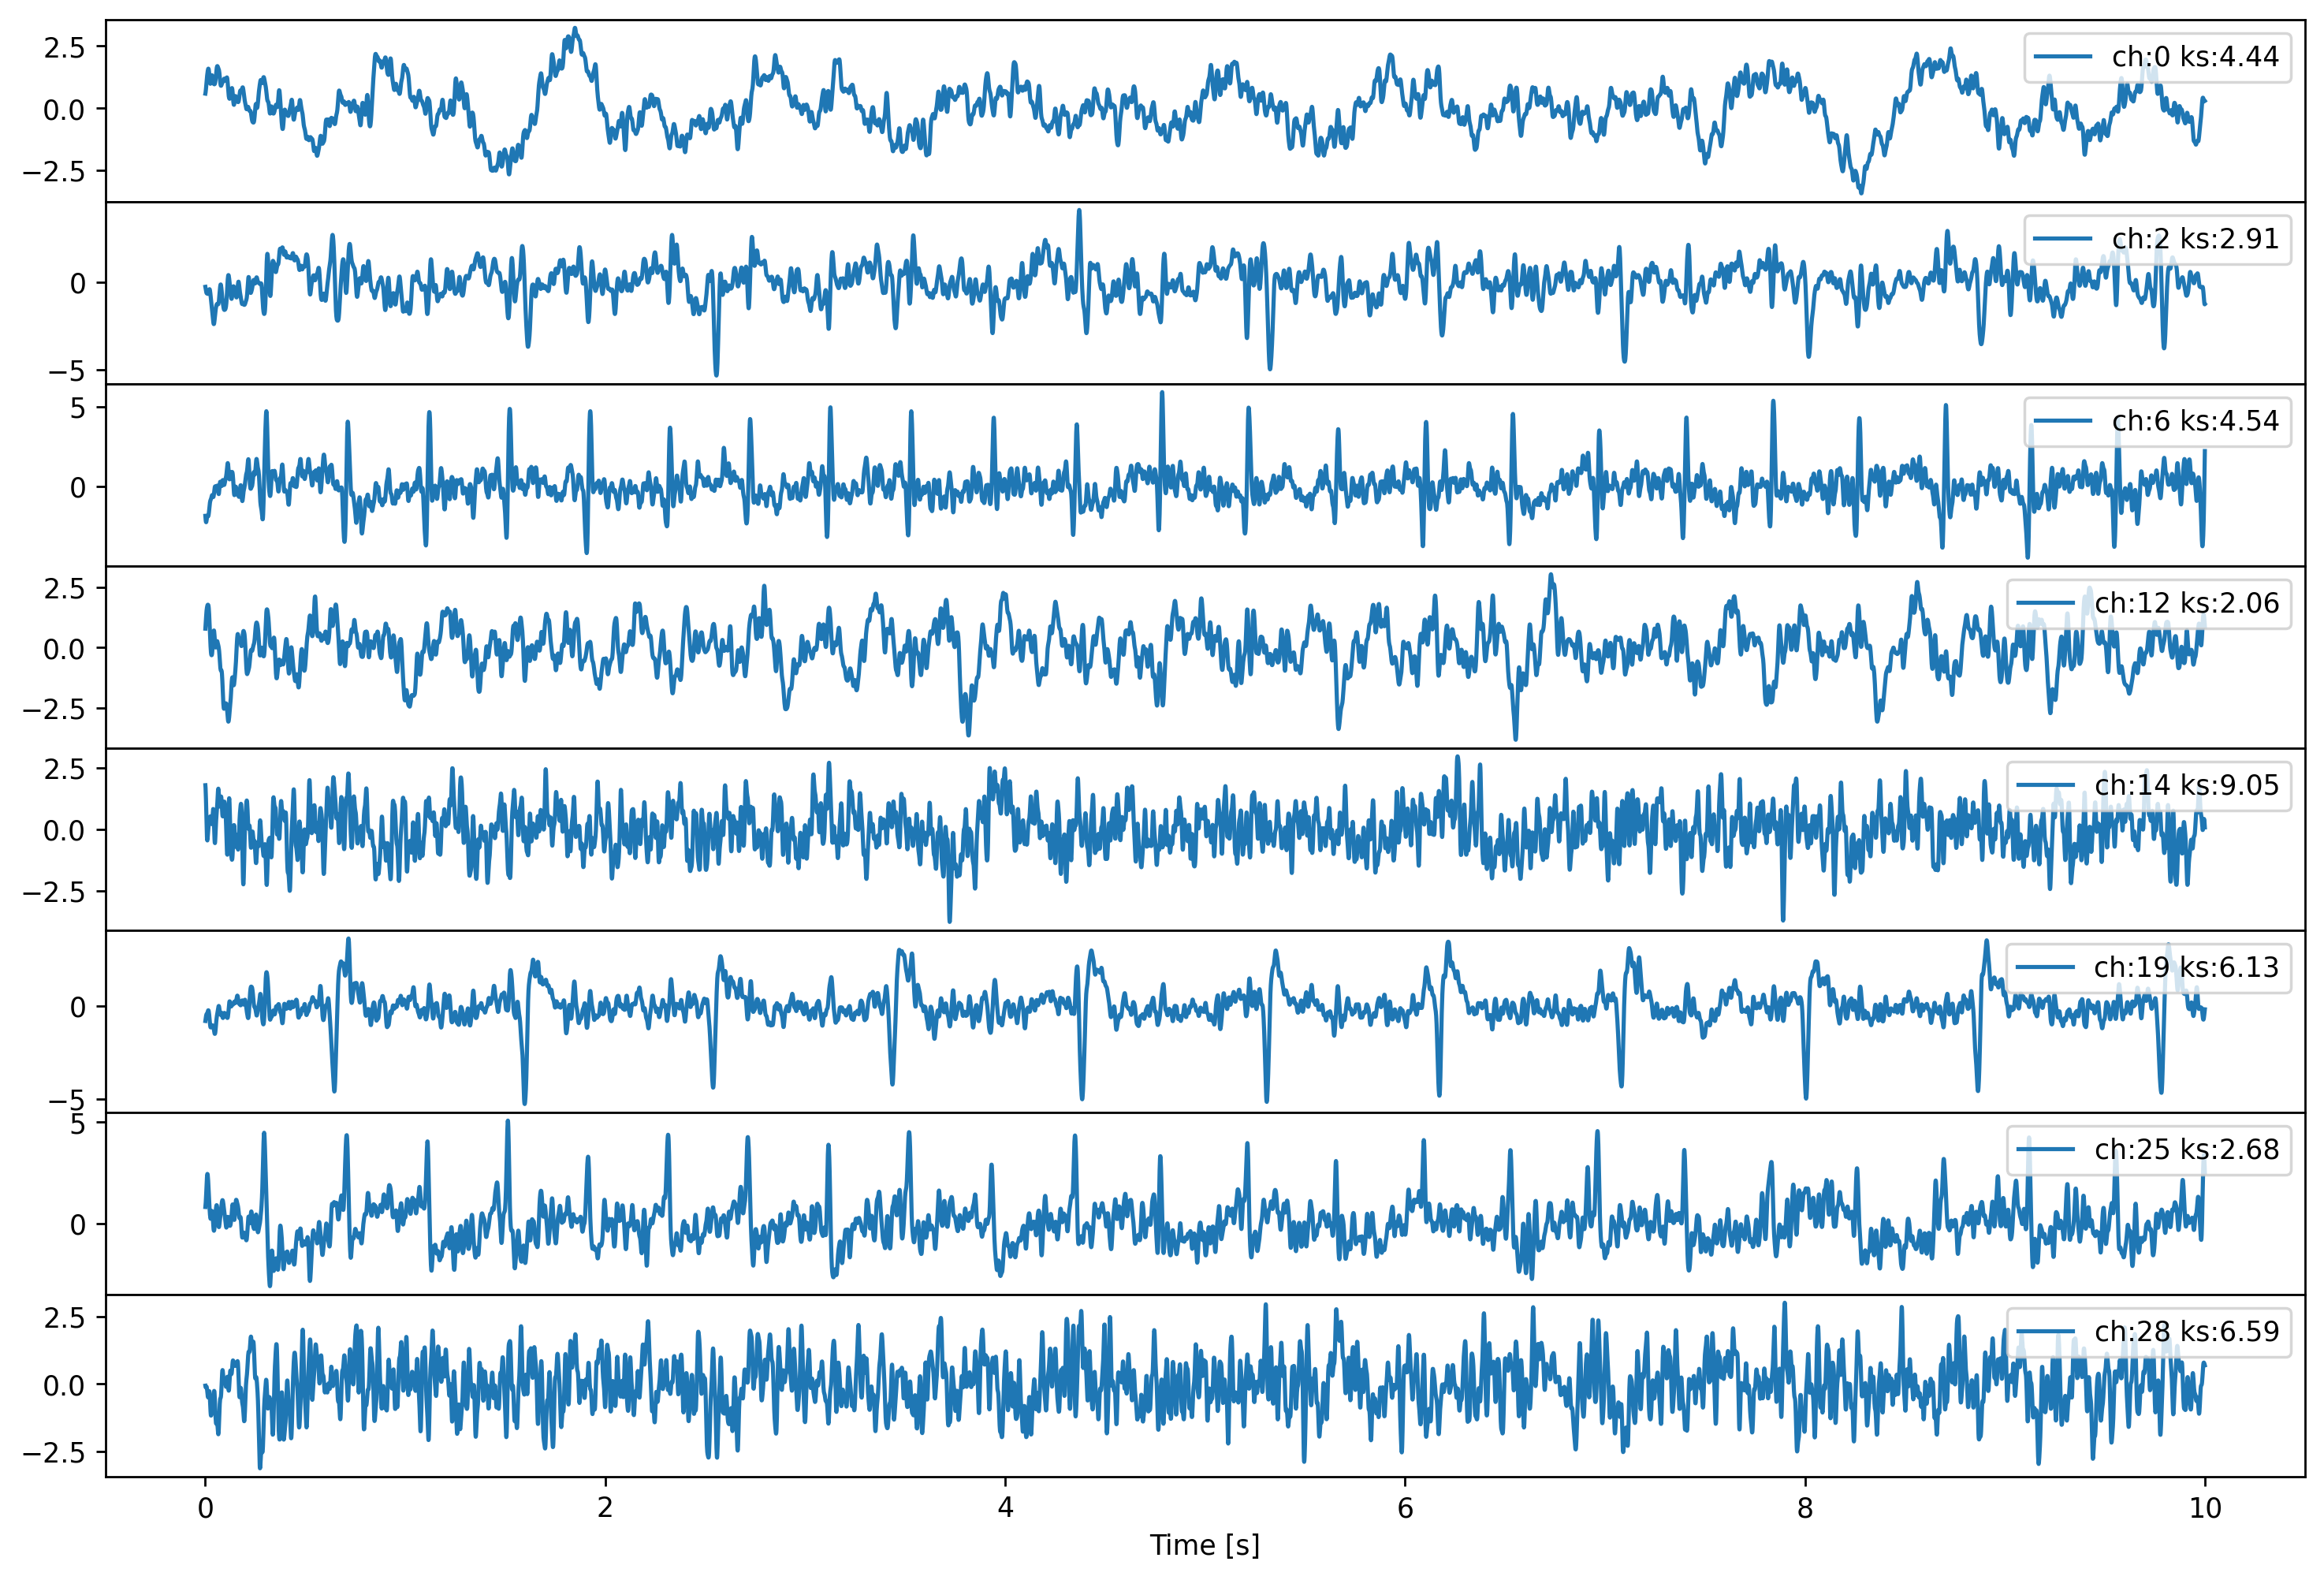

In [6]:

# Identify channels with kurtosis > 2
channels_to_plot = [j for j, kurt in enumerate(kurtosis_values) if kurt > 2 and kurt < 20]

# Set up the subplot grid based on the number of channels to plot
fig, ax = plt.subplots(len(channels_to_plot), 1, sharex=True, figsize=(1.8 * len(channels_to_plot), 1.2 * len(channels_to_plot)), dpi=250)
fig.subplots_adjust(hspace=0)

# Plot only the channels with kurtosis > 2
for i, j in enumerate(channels_to_plot):
    ax[i].plot(ica_applied[offset:offset+span, j], label=f'ch:{j} ks:{kurtosis_values[j]:.2f}')
    ax[i].legend(loc=1)

# Configure the x-axis formatter for the last subplot
ax[-1].xaxis.set_major_formatter(ms2s)
ax[-1].set_xlabel('Time [s]')

# Display the plot
plt.show()

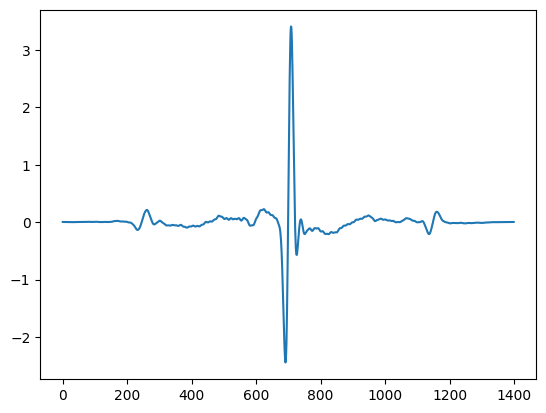

In [12]:
beat, detect = apply_hosd(ica_applied[:,6], window_size) 
plt.plot(beat)

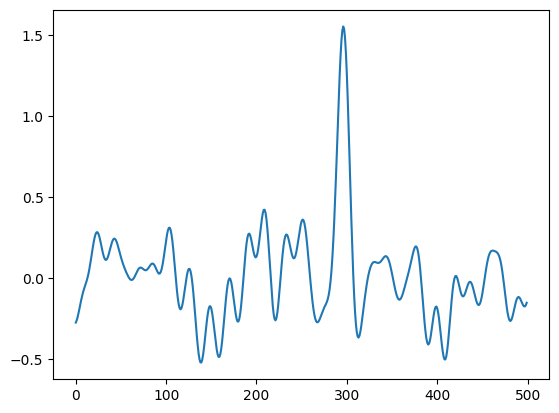

In [14]:
plt.plot(detect[offset:offset+500])

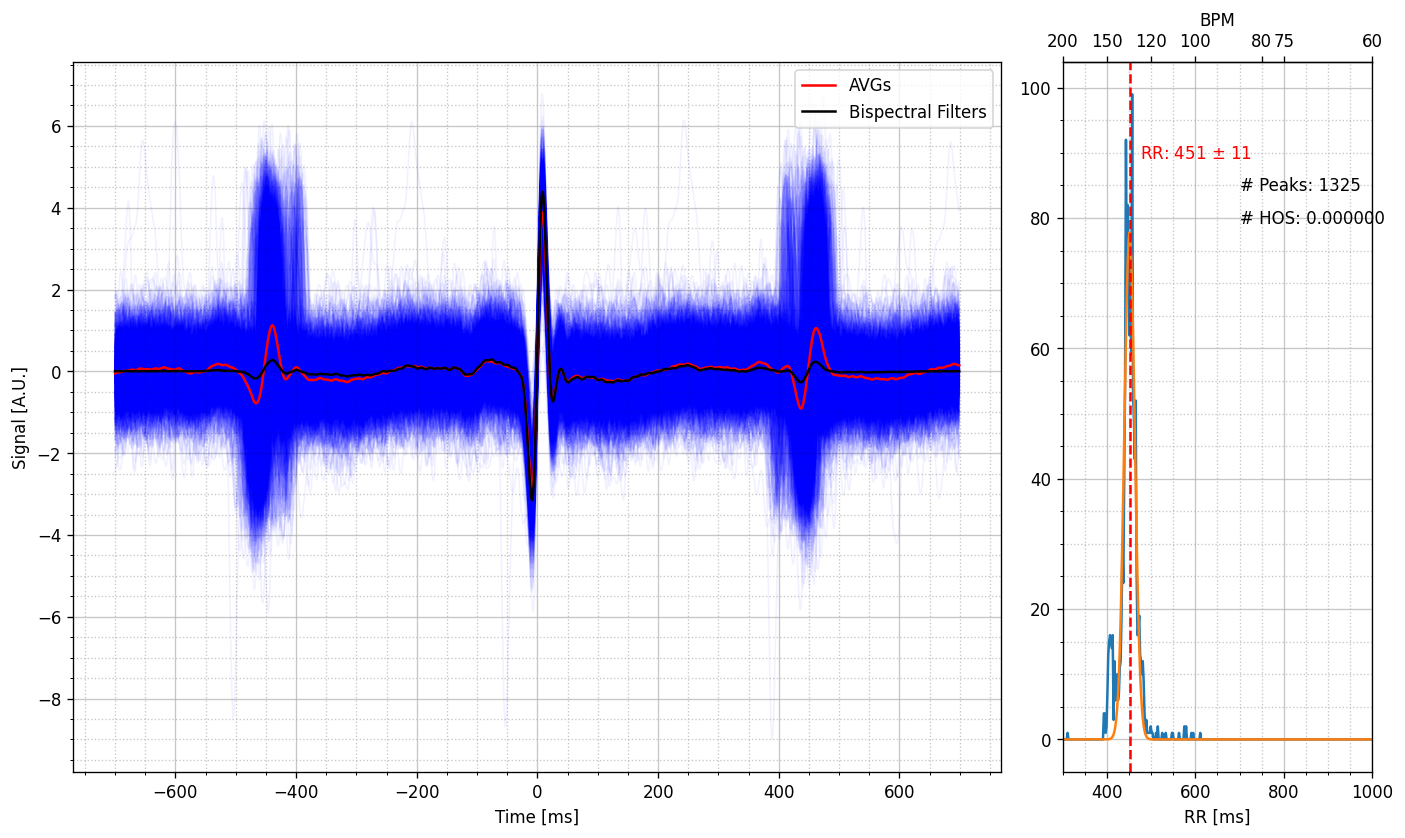

In [8]:
RR, sigma_RR, peaks, popt_RRs, yy, xx = functions.detect_beats(detect)
try:
    savgol_median = savgol_filter(np.diff(peaks), 41, 3)
    avg_peaks_list = peaks[np.where(np.square((np.diff(peaks) - savgol_median) / sigma_RR) < 2)]
except:
    avg_peaks_list = peaks

peaks = avg_peaks_list
if len(peaks)<3:
    print('skipped (low peak count)')
else:
    slice_box, avg_mean,worked = functions.avg_based_QRScomplex(ica_applied[:,6], peaks,sigma_RR, box_size=window_size)
    segmentation_data=functions.waveform_plot(np.array(slice_box), time_axis-window_size/2, add_lines=[avg_mean,beat], sideplot=[xx,yy,popt_RRs,RR,sigma_RR,0])

In [ ]:
], peaks,sigma_RR, box_size=window_size)
    segmentation_data=functions.waveform_plot(np.array(slice_box), time_axis-window_size/2, add_lines=[avg_mean,beat], sideplot=[xx,yy,popt_RRs,RR,sigma_RR,0])